In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
import copy

import sys
sys.path.append("..")

from fdfdpy import Simulation
from structures import three_port, two_port
from optimization import Optimization

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 0.8e-1                 # grid size (L0)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 1             # amplitude of modal source (A/L0^2?)

In [3]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [4]:
# geometric parameters
L = 5         # length of box (L0)
H = 5         # height of box (L0)
w = .3        # width of waveguides (L0)
d = H/1.5    # distance between waveguides (L0)
l = 5         # length of waveguide from PML to box (L0)
spc = 3       # space between box and PML (L0)

Computed a domain with 217 grids in x and 167 grids in y
The simulation has 25 grids per free space wavelength


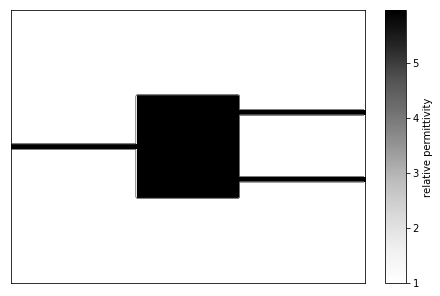

In [5]:
# define permittivity of three port system
eps_r, design_region = three_port(L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [6]:
# check to make sure the number of points in each waveguide is the same
eps = simulation.eps_r
pts_in = np.sum(eps[NPML[0]+3,:] > 1)
pts_top = np.sum(eps[-NPML[0]-3,:ny] > 1)
pts_bot = np.sum(eps[-NPML[0]-3,ny:] > 1)

print('waveguide has {} points in in port'.format(pts_in))
print('waveguide has {} points in top port'.format(pts_top))
print('waveguide has {} points in bottom port'.format(pts_bot))
assert pts_in == pts_top == pts_bot, "number of grid points in each waveguide is not consistent"

waveguide has 3 points in in port
waveguide has 3 points in top port
waveguide has 3 points in bottom port


In [7]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(H/2/dl), scale=source_amp)
simulation.setup_modes()

# top modal profile
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
top.setup_modes()
J_top = np.abs(top.src)

# bottom modal profile
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

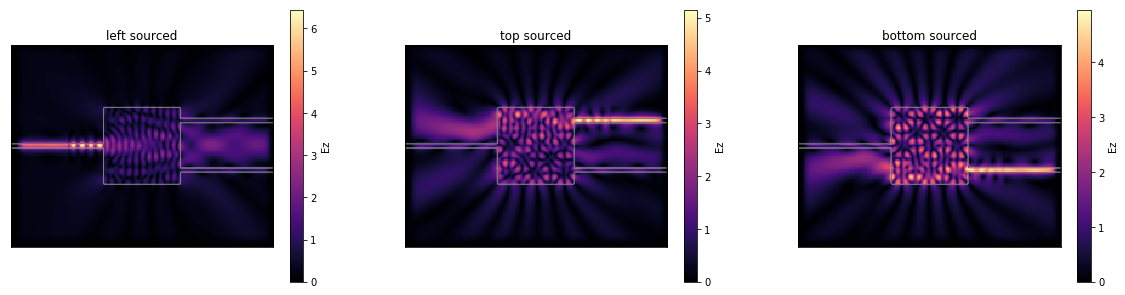

In [8]:
# set source and solve for electromagnetic fields
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

_ = simulation.solve_fields()
_ = top.solve_fields()
_ = bot.solve_fields()

simulation.plt_abs(outline=True, cbar=True, ax=ax1)
top.plt_abs(outline=True, cbar=True, ax=ax2)
bot.plt_abs(outline=True, cbar=True, ax=ax3)
ax1.set_title('left sourced')
ax2.set_title('top sourced')
ax3.set_title('bottom sourced')
plt.show()

In [9]:
# compute straight line simulation
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(H/2/dl), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(H/2/dl))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg))*J_out)
print('computed a scale of {} in units of E^2 J_out'.format(SCALE))

computed a scale of 30.162627604239425 in units of E^2 J_out


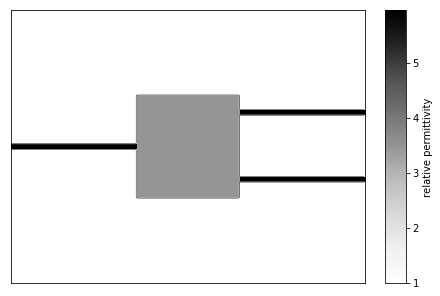

In [10]:
# changes design region. 'style' can be in {'full', 'empty', 'halfway', 'random'}
simulation.init_design_region(design_region, eps_m, style='halfway')
simulation.plt_eps()
plt.show()

In [11]:
# add nonlinearity
nl_region = copy.deepcopy(design_region)
simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

In [12]:
# define objective function
import autograd.numpy as npa
from utils import Binarizer

def J(e, e_nl, eps):
    """ objective function of BOOST means perfect separation between linear and nonlinear
        note: need BOOST if the objective function is too low (source amplitude is low).
        In this case LBFGS just converges and returns before it's actually done.
        Working on this.
    """
    BOOST = 1e10
    linear_top =     1*npa.sum(npa.square(npa.abs(e))*J_top)
    linear_bot =     1*npa.sum(npa.square(npa.abs(e))*J_bot)
    nonlinear_top =  1*npa.sum(npa.square(npa.abs(e_nl))*J_top)
    nonlinear_bot =  1*npa.sum(npa.square(npa.abs(e_nl))*J_bot)
    objfn = ( (linear_top - nonlinear_top) + (nonlinear_bot - linear_bot) ) / 2
    return objfn / SCALE * BOOST

binarizer = Binarizer(design_region, eps_m)
J_bin = binarizer.density(J)

In [13]:
# make optimization object and check derivatives
optimization = Optimization(J=J, Nsteps=1000, eps_max=eps_m, field_start='linear', nl_solver='newton', max_ind_shift=None)

# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(simulation, design_region, Npts=4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [-17.13742983294651, 18.07362400740385, 8.989919233135879, 27.770111293764785]
numerical gradient = [-16.452874297215203, 18.830480692031415, 9.006120521291905, 28.270971258450572]


In [ ]:
# first run the simulation with LBFGS and binary enforcing constraints
optimization.run(simulation, design_region, method='lbfgs')

 ObjectiveFn: 3.3e+09 Iteration:  864/1000 ETA:   0:26:52                      

In [74]:
optimization.J = J_bin
optimization.Nsteps = 10000
optimization.run(simulation, design_region, method='lbfgs')

the simulation did not converge, reached 0.1987765169789838


 ObjectiveFn: 6.1e+09 Iteration:  71/10000 ETA:  2 days, 0:43:54               

the simulation did not converge, reached 0.12609570275830026


 ObjectiveFn: 6.14e+09 Iteration:  108/10000 ETA:  1 day, 22:20:25             

the simulation did not converge, reached 0.2748543869572157


 ObjectiveFn: 6.17e+09 Iteration:  127/10000 ETA:  23:20:05                    

the simulation did not converge, reached 0.4982215264846172


 ObjectiveFn: 6.18e+09 Iteration:  129/10000 ETA:  1 day, 16:38:31             

the simulation did not converge, reached 0.033879720279927604


 ObjectiveFn: 6.18e+09 Iteration:  130/10000 ETA:  4 days, 19:10:24            

the simulation did not converge, reached 0.13825114059250598


 ObjectiveFn: 6.18e+09 Iteration:  131/10000 ETA:  4 days, 5:17:27             

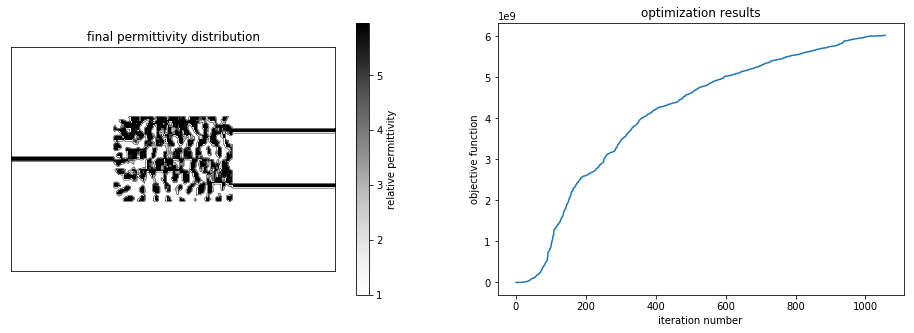

In [66]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2, norm='pow1er')
ax2.set_yscale('linear')
plt.show()

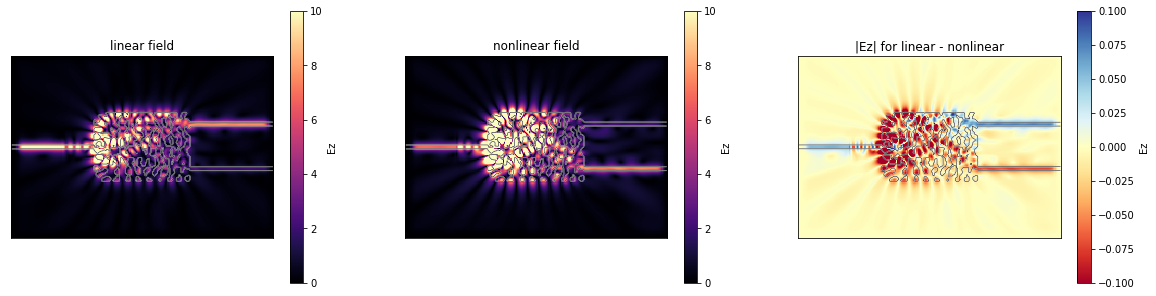

In [64]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1, vmax=10)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2, vmax=10, nl=True)
ax2.set_title('nonlinear field')

# difference
simulation.plt_diff(ax=ax3, vmax=0.1)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

maximum refractive index shift of 0.005494690277878522


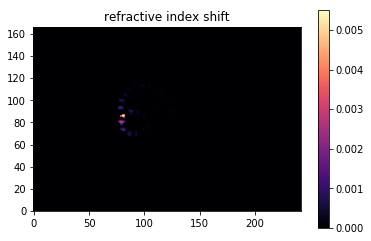

In [68]:
# compute the refractive index shift
index_shift = simulation.compute_index_shift()
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma', origin='lower')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

linear transmission (top)                 = 0.7764
linear transmission (bottom)              = 0.0565
nonlinear transmission (top)              = 0.0751
nonlinear transmission (bottom)           = 0.7340
relative power difference (top)    = 90.32 %
relative power difference (bottom) = 1200.30 %


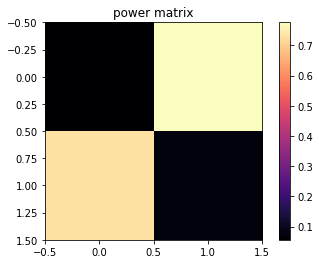

In [63]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_top_lin =  simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny + int(d/2/dl)], int(H/2/dl))
W_bot_lin  = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny - int(d/2/dl)], int(H/2/dl))

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_top_nl =  simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny + int(d/2/dl)], int(H/2/dl), nl=True)
W_bot_nl  = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny - int(d/2/dl)], int(H/2/dl), nl=True)


print('linear transmission (top)                 = {:.4f}'.format(W_top_lin/W_in))
print('linear transmission (bottom)              = {:.4f}'.format(W_bot_lin/W_in))
print('nonlinear transmission (top)              = {:.4f}'.format(W_top_nl/W_in))
print('nonlinear transmission (bottom)           = {:.4f}'.format(W_bot_nl/W_in))
print('relative power difference (top)    = {:.2f} %'.format(100*abs(W_top_lin - W_top_nl) / W_top_lin))
print('relative power difference (bottom) = {:.2f} %'.format(100*abs(W_bot_lin - W_bot_nl)  / W_bot_lin))

S = [[W_bot_lin/W_in, W_top_lin/W_in],
     [W_bot_nl/W_in,  W_top_nl/W_in]]
plt.imshow(S, cmap='magma')
plt.colorbar()
plt.title('power matrix')
plt.show()

 47% (95 of 200) |##########             | Elapsed Time: 0:04:50 ETA:   0:50:21

the simulation did not converge, reached 0.9999749010049649


100% (200 of 200) |######################| Elapsed Time: 0:10:39 ETA:  00:00:00

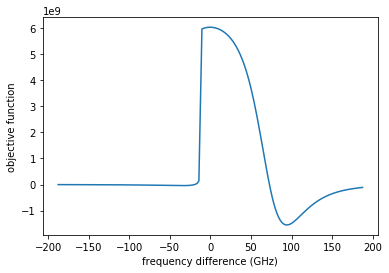

computed FWHM of 67.839195979125 (GHz):


In [70]:
freqs, objs, FWHM = optimization.scan_frequency(Nf=200, df=1/400)
optimization.simulation.omega = omega
plt.plot([(f-150e12)/1e9 for f in freqs], objs)
plt.xlabel('frequency difference (GHz)')
plt.ylabel('objective function')
plt.show()
print('computed FWHM of {} (GHz):'.format(FWHM/1e9))

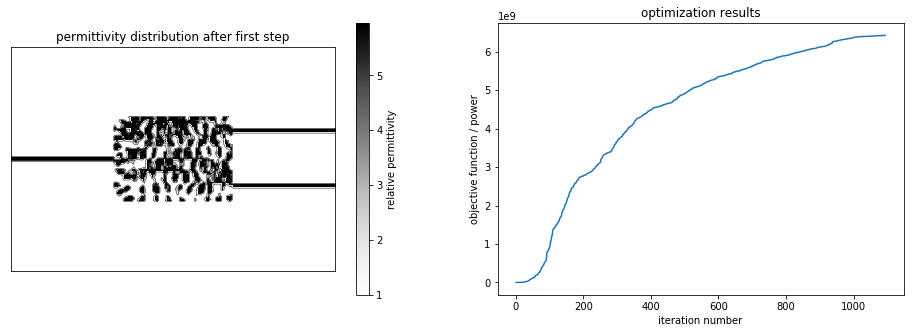

In [71]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1)
ax1.set_title('permittivity distribution after first step')
optimization.plt_objs(ax=ax2, norm='power')
ax2.set_yscale('linear')
plt.show()

In [73]:
np.save('../data/figs/data/3port_eps', simulation.eps_r)
np.save('../data/figs/data/3port_objfn_list', optimization.objfn_list)
np.save('../data/figs/data/3port_freqs', freqs)
np.save('../data/figs/data/3port_objs', objs)